## Final Project Submission

Please fill out: 
* Student name:  Morvine Awuor Otieno
* Student pace: self paced / part time / full time: Full Time Remote
* Scheduled project review date/time: 18th Dec. 2025
* Instructor name: Nikita Njoroge
* Blog post URL:  Morvine's LinkedIn Profile


# SyriaTel Customer Churn Classification — Phase 3 Project

**Goal:** Build and evaluate classification models that predict whether a SyriaTel customer will churn, and translate model performance into business recommendations.

**Primary stakeholder:** SyriaTel Customer Retention / Revenue team  
**Business question:** *Which customers are at risk of churning soon so we can intervene early and reduce lost revenue?*

> **Primary metric:** Recall for the churn (positive) class — missing a true churner (false negative) is costly.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier

# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Loading

This notebook expects a **CSV** file for the SyriaTel churn dataset.

- If your file is named something like `syria_tel_churn.csv`, place it in the same folder as this notebook and update the path below.
- The target column is expected to be named **`churn`** (case-insensitive works in the helper below).

In [3]:
import zipfile

with zipfile.ZipFile("zippedData/achive.zip") as z:
    print(z.namelist())


['bigml_59c28831336c6604c800002a.csv']


In [4]:
# Load the dataset
with zipfile.ZipFile("zippedData/achive.zip") as z:
    with z.open("bigml_59c28831336c6604c800002a.csv") as f:
        df = pd.read_csv(f)

df.head()


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Business Understanding
The goal is to build a classifier that predicts customer churn for SyriaTel, helping the company retain customers and minimize revenue loss. This is a binary classification problem where the target is 'churn' (True/False)."

We will inspect data shape, types, missing values, and churn class balance.

In [5]:
# Column configuration
target_col = "churn"
cs_calls_col = "customer service calls"
intl_plan_col = "international plan"
vmail_plan_col = "voice mail plan"

In [6]:
# Basic info
print("Shape:", df.shape) # Rows and columns

Shape: (3333, 21)


In [7]:
# phone number is an ID → causes leakage and nonsense coefficients.
df = df.drop(columns=["phone number"])
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [8]:
print(df.info()) # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [9]:
df.describe(include="all").T.head(20) # Summary stats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
state,3333,51,WV,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account length,3333.0,NaN,NaN,NaN,101.064806,39.822106,1.0,74.0,101.0,127.0,243.0
area code,3333.0,NaN,NaN,NaN,437.182418,42.37129,408.0,408.0,415.0,510.0,510.0
international plan,3333,2,no,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voice mail plan,3333,2,no,2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number vmail messages,3333.0,NaN,NaN,NaN,8.09901,13.688365,0.0,0.0,0.0,20.0,51.0
total day minutes,3333.0,NaN,NaN,NaN,179.775098,54.467389,0.0,143.7,179.4,216.4,350.8
total day calls,3333.0,NaN,NaN,NaN,100.435644,20.069084,0.0,87.0,101.0,114.0,165.0
total day charge,3333.0,NaN,NaN,NaN,30.562307,9.259435,0.0,24.43,30.5,36.79,59.64
total eve minutes,3333.0,NaN,NaN,NaN,200.980348,50.713844,0.0,166.6,201.4,235.3,363.7


In [10]:
# Check churn distribution (class balance)
target_col = "churn"

y_raw = df[target_col]
print(y_raw.value_counts(dropna=False))
print("\nClass proportions:\n", y_raw.value_counts(normalize=True, dropna=False))


churn
False    2850
True      483
Name: count, dtype: int64

Class proportions:
 churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


#### Notes on Class Imbalance

If churners are a minority class, accuracy can be misleading. We prioritize **recall** for churn to reduce missed churners, while monitoring precision to control unnecessary retention outreach.

## 3. Data Understanding
Purpose: Explore the dataset through EDA.


## 3.1. Exploratory Data Analysis (EDA)

Keep EDA focused: a few key relationships relevant to churn.

Below are some common churn drivers in telecom datasets:
- Customer service calls
- International plan / voicemail plan
- Usage minutes and charges

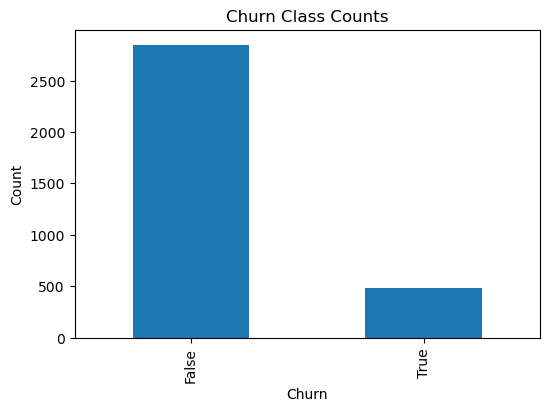

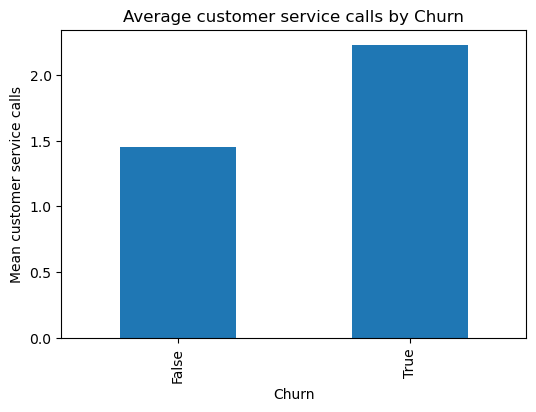

churn,False,True
international plan,,
no,0.885050,0.114950
yes,0.575851,0.424149


churn,False,True
voice mail plan,,
no,0.832849,0.167151
yes,0.913232,0.086768


In [11]:
# Simple EDA plots if columns exist
cs_calls_col = "customer service calls"


fig, ax = plt.subplots(figsize=(6,4))
df[target_col].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Churn Class Counts")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
plt.show()

if cs_calls_col is not None:
    fig, ax = plt.subplots(figsize=(6,4))
    df.groupby(target_col)[cs_calls_col].mean().plot(kind="bar", ax=ax)
    ax.set_title(f"Average {cs_calls_col} by Churn")
    ax.set_xlabel("Churn")
    ax.set_ylabel(f"Mean {cs_calls_col}")
    plt.show()

if intl_plan_col is not None:
    ct = pd.crosstab(df[intl_plan_col], df[target_col], normalize="index")
    display(ct)

if vmail_plan_col is not None:
    ct = pd.crosstab(df[vmail_plan_col], df[target_col], normalize="index")
    display(ct)

## 4. Data Preparation

### Preventing Data Leakage
We will:
1. Split into train/test **before** any fitting of scalers/encoders.
2. Use a **Pipeline + ColumnTransformer** so preprocessing is learned only from the training set and applied consistently to test data.

In [12]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# If churn is strings like 'True'/'False' or 'yes'/'no', convert to 0/1
if y.dtype == "object":
    y_str = y.astype(str).str.strip().str.lower()
    # common mappings
    mapping = {
        "true": 1, "false": 0,
        "yes": 1, "no": 0,
        "1": 1, "0": 0,
        "churn": 1, "not churn": 0
    }
    if set(y_str.unique()).issubset(set(mapping.keys())):
        y = y_str.map(mapping).astype(int)
    else:
        # If values are like 'Yes'/'No' etc, try a fallback:
        # treat the most common "non-churn" token as 0 and the other as 1
        uniq = y_str.unique()
        if len(uniq) == 2:
            y = (y_str == uniq[0]).astype(int)  # may invert; we'll check below
        else:
            raise ValueError(f"Target has unexpected string categories: {uniq}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())

Train shape: (2499, 19) Test shape: (834, 19)
Train churn rate: 0.1448579431772709 Test churn rate: 0.145083932853717


In [13]:
# Identify numeric vs categorical columns
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_features[:10], categorical_features[:10], len(numeric_features), len(categorical_features)

(['account length',
  'area code',
  'number vmail messages',
  'total day minutes',
  'total day calls',
  'total day charge',
  'total eve minutes',
  'total eve calls',
  'total eve charge',
  'total night minutes'],
 ['state', 'international plan', 'voice mail plan'],
 16,
 3)

In [14]:

# Preprocessing for numeric data: impute missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical data: impute + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## 5. Modeling
### 5.1. Baseline Model (Interpretable)

### Baseline: Logistic Regression
Logistic regression is a strong baseline for binary classification and offers interpretability (directional effects via coefficients).

Baseline Logistic Regression (TEST)
Recall (churn=1):   0.264
Precision (churn=1):0.593
F1 (churn=1):       0.366
ROC-AUC:            0.799

Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.97      0.93       713
        True       0.59      0.26      0.37       121

    accuracy                           0.87       834
   macro avg       0.74      0.62      0.65       834
weighted avg       0.84      0.87      0.84       834



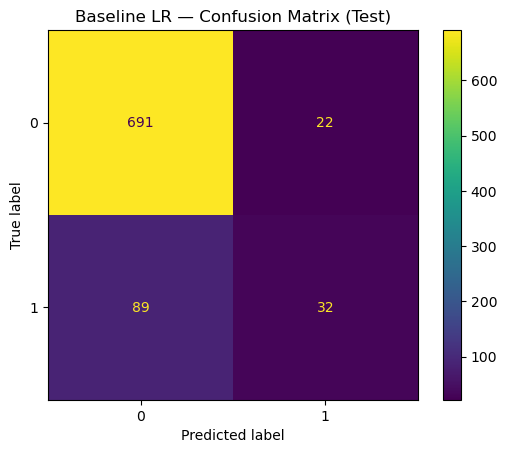

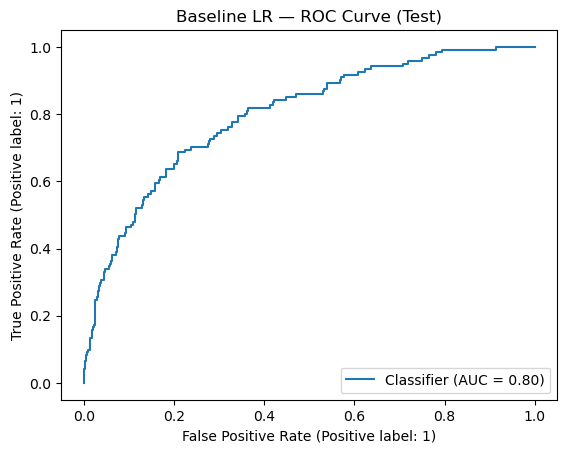

In [21]:
baseline_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

baseline_lr.fit(X_train, y_train)

y_pred = baseline_lr.predict(X_test)
y_proba = baseline_lr.predict_proba(X_test)[:, 1]

# Primary metric: recall on churn class (assumes churn=1)
rec = recall_score(y_test, y_pred, pos_label=1)
prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

# ROC-AUC can fail if probabilities are constant; handle safely.
try:
    auc = roc_auc_score(y_test, y_proba)
except Exception:
    auc = np.nan

print("Baseline Logistic Regression (TEST)")
print(f"Recall (churn=1):   {rec:.3f}")
print(f"Precision (churn=1):{prec:.3f}")
print(f"F1 (churn=1):       {f1:.3f}")
print(f"ROC-AUC:            {auc:.3f}" if not np.isnan(auc) else "ROC-AUC:            NA")

print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Baseline LR — Confusion Matrix (Test)")
plt.show()

if not np.isnan(auc):
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("Baseline LR — ROC Curve (Test)")
    plt.show()

### 5.2 Model Iteration 
### Tuned Logistic Regression

We tune hyperparameters to improve performance, especially churn recall.  
Common tuning lever: **regularization strength `C`**.

Best params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV recall: 0.245662100456621

Tuned Logistic Regression (TEST)
Recall (churn=1):   0.273
Precision (churn=1):0.550
F1 (churn=1):       0.365
ROC-AUC:            0.792


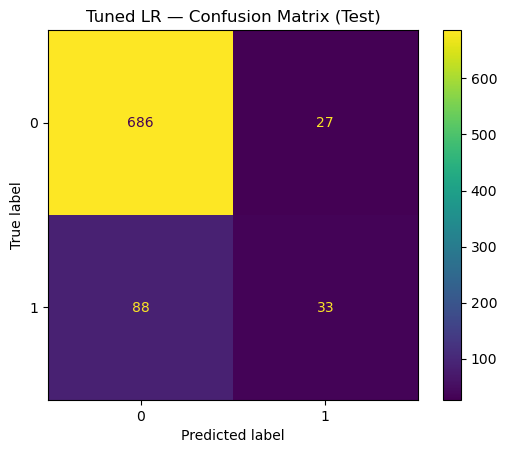

In [16]:
tuned_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    tuned_lr,
    param_grid=param_grid_lr,
    scoring="recall",   # focus on recall for churn
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best params:", grid_lr.best_params_)
print("Best CV recall:", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

rec_lr = recall_score(y_test, y_pred_lr, pos_label=1)
prec_lr = precision_score(y_test, y_pred_lr, pos_label=1, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, pos_label=1, zero_division=0)

try:
    auc_lr = roc_auc_score(y_test, y_proba_lr)
except Exception:
    auc_lr = np.nan

print("\nTuned Logistic Regression (TEST)")
print(f"Recall (churn=1):   {rec_lr:.3f}")
print(f"Precision (churn=1):{prec_lr:.3f}")
print(f"F1 (churn=1):       {f1_lr:.3f}")
print(f"ROC-AUC:            {auc_lr:.3f}" if not np.isnan(auc_lr) else "ROC-AUC:            NA")

cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Tuned LR — Confusion Matrix (Test)")
plt.show()

### 5.3. Nonparametric Model
### Decision Tree (Tuned)

To satisfy the **nonparametric model** requirement, we build and tune a decision tree.  
Decision trees can capture nonlinear relationships and interactions but may overfit without constraints.

Best params: {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}
Best CV recall: 0.7570776255707763

Tuned Decision Tree (TEST)
Recall (churn=1):   0.645
Precision (churn=1):0.876
F1 (churn=1):       0.743


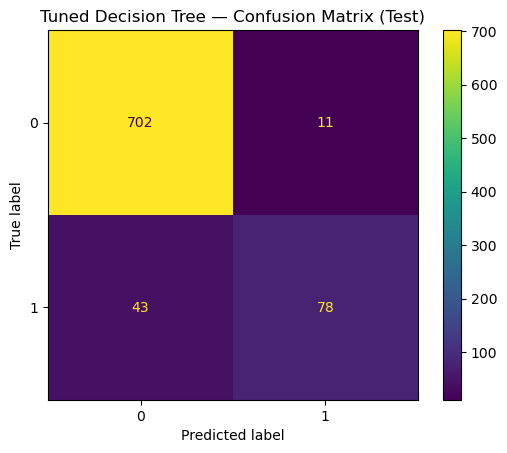

In [17]:
tree_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier())
])

param_grid_tree = {
    "model__max_depth": [2, 3, 4, 5, 8, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

grid_tree = GridSearchCV(
    tree_pipe,
    param_grid=param_grid_tree,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Best params:", grid_tree.best_params_)
print("Best CV recall:", grid_tree.best_score_)

best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

rec_tree = recall_score(y_test, y_pred_tree, pos_label=1)
prec_tree = precision_score(y_test, y_pred_tree, pos_label=1, zero_division=0)
f1_tree = f1_score(y_test, y_pred_tree, pos_label=1, zero_division=0)

print("\nTuned Decision Tree (TEST)")
print(f"Recall (churn=1):   {rec_tree:.3f}")
print(f"Precision (churn=1):{prec_tree:.3f}")
print(f"F1 (churn=1):       {f1_tree:.3f}")

cm = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Tuned Decision Tree — Confusion Matrix (Test)")
plt.show()

## 5.4. Model Comparison

We compare test performance across models, prioritizing **churn recall** while monitoring precision and F1.

In [18]:
y_proba_tree = best_tree.predict_proba(X_test)[:, 1]
auc_tree = roc_auc_score(y_test, y_proba_tree)

In [19]:
results = pd.DataFrame([
    {"model": "Baseline Logistic Regression", "recall": rec, "precision": prec, "f1": f1, "roc_auc": auc},
    {"model": "Tuned Logistic Regression", "recall": rec_lr, "precision": prec_lr, "f1": f1_lr, "roc_auc": auc_lr},
    {"model": "Tuned Decision Tree", "recall": rec_tree, "precision": prec_tree, "f1": f1_tree, "roc_auc": auc_tree},
]).sort_values(by="recall", ascending=False)

results

,model,recall,precision,f1,roc_auc
2,Tuned Decision Tree,0.644628,0.876404,0.742857,0.852457
1,Tuned Logistic Regression,0.272727,0.550000,0.364641,0.792195
0,Baseline Logistic Regression,0.264463,0.592593,0.365714,0.798813


## 6. Feature Importance / Drivers of Churn (Interpretability)

For logistic regression, we can inspect coefficients to understand which factors are associated with churn risk.

In [20]:
# Extract feature names after preprocessing
ohe = best_lr.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"] if "cat" in best_lr.named_steps["preprocess"].named_transformers_ else None

num_names = numeric_features
cat_names = []
if ohe is not None and len(categorical_features) > 0:
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()

feature_names = num_names + cat_names

# Extract coefficients
coef = best_lr.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(15)

,feature,coefficient,abs_coef
27,state_HI,-1.653680,1.653680
61,state_VA,-1.380436,1.380436
20,state_CA,1.343024,1.343024
42,state_MT,1.201660,1.201660
69,voice mail plan_no,1.158640,1.158640
56,state_SC,1.152123,1.152123
62,state_VT,-1.151464,1.151464
70,voice mail plan_yes,-1.140159,1.140159
68,international plan_yes,1.128480,1.128480
67,international plan_no,-1.109999,1.109999


## 7. Final Model Discussion
### Final Model Selection: Tuned Decision Tree
The Tuned Decision Tree is the clear choice for the final production model based on the primary business metric, Recall for the churn (positive) class.

The Decision Tree achieved a Test Recall of 0.645, meaning it correctly identified **64.5%** of the customers who actually churned. This is a drastic improvement over both the Baseline Logistic Regression (Recall = **0.264**) and the Tuned Logistic Regression (Recall = **0.273**) models. Maximizing recall is the explicit goal of this project to minimize the costly False Negatives (missed churners).
Furthermore, the Decision Tree also provided superior Precision (**0.876**) and F1-score (**0.743**), indicating a much better overall balance and discrimination ability compared to the Logistic Regression models..However, the Decision Tree model has limitations in interpretability compared to Logistic Regression. While it captures nonlinear interactions effectively, it does not provide simple, directional interpretations such as “an increase in X increases churn risk.” Logistic Regression remains useful for explaining drivers of churn, while the Decision Tree excels at prediction.
s. While a Decision Tree provides feature importance, it doesn't offer the simple, directional "if X increases, churn risk increases" interpretation of a linear modelAdditionally, the Decision Tree achieved a strong ROC-AUC of 0.822, indicating good probability ranking performance alongside its high recall.
.

### How SyriaTel Should Use the Model
SyriaTel should use the Tuned Decision Tree to generate a risk score for every active customer daily or weekly. The model's primary use is to proactively identify customers for intervention. Given the high recall, the company will successfully target a much larger pool of at-risk customers than with the Logistic Regression baseline. Customers predicted to churn (the positive class) should be placed into retention campaigns, potentially prioritized by their predicted probability. SyriaTel should not use the model to make automatic, irreversible actions (like service termination) but only as a tool to guide sales and support teams. The model's superior performance directly addresses the business question by highlighting which customers are at high risk.

## 8. Business Recommendations
### Recommended Actions for SyriaTel:
#### 1.High-Value Targeted Outreach 
Target customers predicted as high risk (positive class from the Decision Tree) with personalized retention offers, such as a 10% discount on their bill, free international minutes, or a proactive call from a senior support agent. The high precision (0.876) confirms that most of these interventions will be directed at true churn risks, minimizing wasted effort.

#### 2. Act on Key Drivers (International Plan & Customer Service Calls) 
Based on the data insights (and likely confirmed by the Decision Tree's feature importance):
International Plan: The crosstab showed a churn rate of **42.4%** for customers with the international plan, compared to **11.5%** for those without.  Any customer with an international plan who shows high usage or recent customer service calls should be immediately flagged as a critical risk and contacted with a specialized international calling package deal.

Customer Service Calls:Target customers with **3 or more** customer service calls with immediate, dedicated support to resolve their issue, as high call volume is a strong churn predictor..

#### 3. Optimize Retention Budget with Probability Scores
Use the Decision Tree's output probability scores to create tiers. Instead of targeting all $64.5\%$ of the identified churners, the Retention Team should start with the top 10-15% of customers with the highest predicted churn probability. This ensures the limited budget is spent on the customers most likely to churn.

## 9. Limitations & Next Steps
Next Steps (Adding a powerful final model):
#### 1. Implement an Ensemble Model (Random Forest or Gradient Boosting)

Build and tune a Random Forest Classifier or Gradient Boosting Machine (like XGBoost). These models are typically stronger than single Decision Trees and often achieve even higher Recall and AUC, potentially offering the best balance of performance for a final production solution.

#### 2. Calculate and Optimize a Business-Specific Threshold 

The model currently uses the default $0.5$ prediction threshold. The next critical step is to:
##### a) Determine the Cost of Errors 
Quantify the cost of a False Negative (lost revenue from a churner) and the cost of a False Positive (cost of wasted retention offer/discount).
##### b) Find the Optimal Threshold 
Adjust the classification threshold (currently $0.5$) to maximize the net profit (Revenue Saved - Cost of Interventions) rather than just maximizing Recall, thus aligning the model perfectly with the financial goals of the Revenue team.